In [1]:
import torch
import numpy as np
import pandas as pd
from matplotlib.pyplot import savefig

In [2]:
### Class that simulates evolution of bee hive
cos = torch.cos
sin = torch.sin
e = torch.exp
class Hive:
    def __init__(self,**hive):
        for k,v in hive.items():
            setattr(self,k,v)
    ## dynamics
    def dB_o(self,hive):
        return self.L * self.S(hive) - self.phi_o*hive['B_o']
    def dB_c(self,hive):
        return self.phi_o*hive['B_o'] - self.phi_c*hive['B_c'] - self.m_c*hive['B_c']
    def dH(self,hive):
        return self.phi_c*hive['B_c'] - self.Rp(hive)*hive['H'] - self.Rn(hive)*hive['H']
    def dF_p(self,hive):
        return self.Rp(hive)*hive['H'] - self.m_p*hive['F_p']
    def dF_n(self,hive):
        return self.Rn(hive)*hive['H'] - self.m_n*hive['F_n']
    def df_p(self,hive):
        return self.mu_p(hive)*self.c*hive['F_p'] - \
            self.gamma_bo*hive['B_o'] - self.gamma_h*hive['H'] 
    def df_n(self,hive):
        return self.mu_n(hive)*self.c*hive['F_n'] - \
            self.delta_bo*hive['B_o'] - self.delta_A*(hive['H']+hive['F_p']+hive['F_n'])
    def update_bees(self,hive):
        bees = {'B_o':hive['B_o']+self.dB_o(hive),
                'B_c':hive['B_c']+self.dB_c(hive),
                'H':hive['H']+self.dH(hive),
                'F_p':hive['F_p']+self.dF_p(hive),
                'F_n':hive['F_n']+self.dF_n(hive),
                'f_p':hive['f_p']+self.df_p(hive),
                'f_n':hive['f_n']+self.df_n(hive),
                't':hive['t']+1}
        return bees
    ## survival and transition functions
    def S(self,hive):
        H,f_n,f_p = hive['H'],hive['f_n'],hive['f_p']
        v,b,K = self.v,self.b,self.K
        return H/(H+v)*f_n/(f_n+b)*f_p**2/(f_p**2+K*H)
    def Rp(self,hive):
        f_p,F_p,F_n,H = hive['f_p'],hive['F_p'],hive['F_n'],hive['H']
        a_min,a_max,K,delta = self.amin_p,self.amax_p,self.K,self.delta
        return a_min + a_max*(1-f_p**2/(f_p**2+K*H)) - delta*F_p/(F_p+F_n+H)
    def Rn(self,hive):
        f_n,F_p,F_n,H = hive['f_n'],hive['F_p'],hive['F_n'],hive['H']
        a_min,a_max,b,delta = self.amin_n,self.amax_n,self.b,self.delta
        return a_min + a_max*(1-f_n/(f_n+b)) - delta*F_n/(F_p+F_n+H)
    def mu_p(self,hive):
        return 0.5*(sin(hive['t']*np.pi/180 + np.pi/4)+2.5)
    def mu_n(self,hive):
        return 0.5*(sin(hive['t']*np.pi/180 + np.pi/8)+2.5)

In [3]:
class Hive2(Hive):
    def __init__(self, **hive):
        super().__init__(**hive)
        
    def S(self,hive):
        H,f_n,f_p = hive['H'],hive['f_n'],hive['f_p']
        s_H,s_p,s_n = self.s_H,self.s_p,self.s_n
        return 0.8*(1-e(-s_H*H))*(1-e(-s_p*f_p))*(1-e(-s_n*f_n))
    def Rp(self,hive):
        f_p,f_n,F_p,F_n,H = hive['f_p'],hive['f_n'],hive['F_p'],hive['F_n'],hive['H']
        r_p,r_I,b = self.r_p,self.r_I,self.b
        return b*(1-0.5*e(-r_p*(f_p/(f_p+f_n+0.01))))*(1-e(-r_I*(H/(H+F_p+F_n))))
    def Rn(self,hive):
        f_p,f_n,F_p,F_n,H = hive['f_p'],hive['f_n'],hive['F_p'],hive['F_n'],hive['H']
        r_n,r_I,b = self.r_n,self.r_I,self.b
        return b*(1-0.5*e(-r_n*(f_p/(f_p+f_n+0.01))))*(1-e(-r_I*(H/(H+F_p+F_n))))

In [4]:
### function that runs hive simulation over multiple time steps, typically one year
def simulate_hive(hive_args,bees,time_steps,hive_class=Hive):
    '''
    run hive through consecutive days
    hive_args: dict containing hive parameters that determine how hive evolves from one day to the next
    bees: dict containing initial counts of brood, capped brood, hive bees, pollen foragers, nectar foragers, and store of nectar and pollen
    time_steps: number of days to run simulation over
    hive_class: Hive or a subclass of Hive that implements the hive
    '''
    hive = hive_class(**hive_args)
    all_bees = [bees]
    hive_out = [[v.item() for v in all_bees[-1].values()]]
    for step in range(time_steps):
        all_bees.append(hive.update_bees(all_bees[-1]))
        hive_out.append([v.item() for v in all_bees[-1].values()])
    hive_out = pd.DataFrame(hive_out,columns = list(bees.keys())).set_index('t')
    return hive_out,all_bees

In [5]:
### extract derivatives with respect to different input parameters
def get_derivs(hives,hive_args_torch,normalize = True):
    '''
    function to extract derivatives from simulation output
    hives: list of dicts, for each day of simulation, containing counts of bees and store of pollen/nectar
    hive_args: dict with simulation parameters, we will take derivative of each output count with respect to each parameter
    normalize: whether or not to adjust derivatives to represent change of 1% of magnitude of simulation parameter
    '''
    derivs = {}
    for k,v in hives[-1].items():
        if k != 't':
            v.backward(retain_graph=True)
            derivs[k] = pd.Series({k2:v2.grad.item() for k2,v2 in hive_args_torch.items()})
            for v2 in hive_args_torch.values():
                v2.grad = None
    derivs = pd.concat(derivs,axis=1)
    if normalize:
        val = pd.Series({k:v.item() for k,v in hive_args_torch.items()})
        val1pct = val*0.01
        derivs = derivs.mul(val1pct,0)
    return derivs

In [6]:
### present results
def present_results(all_bees, derivs, scenario, save_dir = '/home/max/work/challenge/graphs/'):
    #all_bees.columns = ['Young Brood','Capped Brood','Hive Bees','Pollen Foragers','Nectar Foragers','Pollen Stored','Nectar Stored']
    all_bees.columns = ['Young','Brood','HiveB','Pollen F','Nectar F','Pollen','Nectar']
    derivs.columns = all_bees.columns
    all_bees.iloc[:,:5].plot(grid=True,title=f'Bee counts in {scenario} scenario')
    if save_dir is not None:
        savefig(f'{save_dir}{scenario}_bee_counts.pdf',dpi=150)
    (all_bees.iloc[:,5:]*1e-3).plot(grid=True,title=f'Food stored in {scenario} scenario')
    if save_dir is not None:
        savefig(f'{save_dir}{scenario}_food_store.pdf',dpi=150)
    derivs.index = ['eggs','hive_bees_for_brood_surv','nectar_for_brood_surv','pollen_recruit_rate_1','pollen_recruit_rate_2','nectar_rectuit_rate_1',
                    'nectar_recruit_rate_2','excess_foragers','1/larva_duration','1/capped_duration','pollen_eaten_per_brood','nectar_eaten_per_brood',
                    'pollen_eaten_per_hiveb','nectar_eaten_per_worker','food_gathered_per_worker','mortality_capped','mortatiliy_pollen',
                    'mortality_nectar','nurse_bee_protein_sat']
    derivs.drop('mortality_capped')
    if save_dir is not None:
        der2 = derivs.copy()
        #der2.iloc[:,5:] *= 1e-3 # convert grams to kg
        s = der2.style.highlight_max()
        s.clear(); s.table_styles = []
        s.format(precision=1)
        s.format_index(escape='latex')
        #s.format({'font-size':'8px'})
        s.to_latex(f'{save_dir}{scenario}_derivs.tex',hrules=True)
    return s

In [7]:
### typical parameters representing hive
hive_args = \
    {'L': 2000,        # number of eggs per day
     'v': 5000,        # number of hive bees corresponding to survival of eggs of 50%
     'b': 500,         # how much nectar needs to be stored corresponding to survival of eggs of 50%
     'amin_p': 0.25,   # recruitment rate 1 for hive bees to become pollen foragers
     'amax_p': 0.25,   # recruitment rate 2 for hive bees to become pollen foragers
     'amin_n': 0.25,   # recruitment rate 1 for hive bees to become nectar foragers
     'amax_n': 0.25,   # recruitment rate 2 for hive bees to become nectar foragers
     'delta': 0.75,    # effect of excess foragers on recruitment
     'phi_o': 1/9,     # 1/(duration of egg + larva state)
     'phi_c': 1/12,    # 1/(duration of capped brood state)
     'delta_bo': 0.018,# daily nectar consumption of uncapped brood member
     'gamma_bo': 0.018,# daily pollen consumption of uncapped brood member
     'gamma_h': 0.007, # daily pollen consumption of hive bee
     'delta_A': 0.007, # daily nector consumption of adult forager bee
     'c': 0.1,         # food gathered per day by forager
     'm_c':0,          # daily mortality rate of capped brood
     'm_p':0.1,        # daily mortality rate of pollen forager
     'm_n':0.1,        # daily mortality rate of nectar forager
     'K':8.0}          # maximum amount of protein that saturates nurse bee
hive_args_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in hive_args.items()}

In [8]:
### base case bee counts
bees = dict(zip(['B_o','B_c','H','F_p','F_n','f_p','f_n','t'],[0.0,0.0,16000.0,2000.0,6000.0,0.0,0.0,0.0]))
print(bees)
bees = {k:torch.Tensor([v]) for k,v in bees.items()}

{'B_o': 0.0, 'B_c': 0.0, 'H': 16000.0, 'F_p': 2000.0, 'F_n': 6000.0, 'f_p': 0.0, 'f_n': 0.0, 't': 0.0}


,Young,Brood,HiveB,Pollen F,Nectar F,Pollen,Nectar
eggs,180.4,240.6,184.0,100.2,100.3,2042.7,1659.3
hive\_bees\_for\_brood\_surv,-49.7,-66.3,-50.8,-27.7,-27.7,-723.8,-611.3
nectar\_for\_brood\_surv,-0.9,-1.3,-1.5,-0.7,-0.4,-67.0,-34.0
pollen\_recruit\_rate\_1,-42.6,-56.8,-155.2,12.3,-59.7,1017.6,-1529.2
pollen\_recruit\_rate\_2,-0.0,-0.1,-0.1,-0.0,-0.0,-27.8,-47.8
nectar\_rectuit\_rate\_1,-40.8,-54.3,-152.4,-58.4,13.2,-1561.2,1135.8
nectar\_recruit\_rate\_2,-0.2,-0.3,-0.6,-0.3,0.0,-69.5,-12.5
excess\_foragers,65.3,87.1,241.0,36.2,36.3,473.8,318.3
1/larva\_duration,-129.4,0.9,1.1,0.5,0.3,920.6,902.1
1/capped\_duration,0.2,-173.0,0.3,0.2,0.1,212.0,199.7


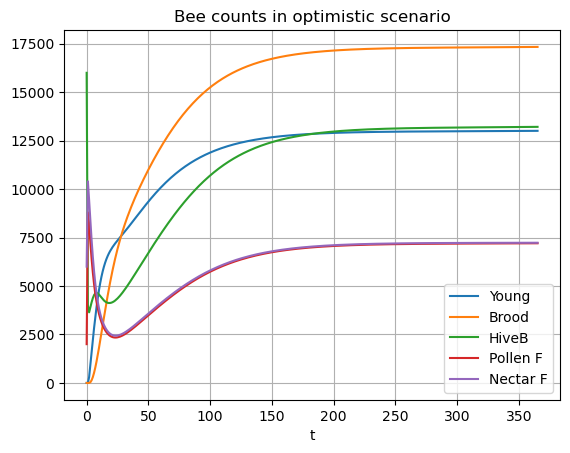

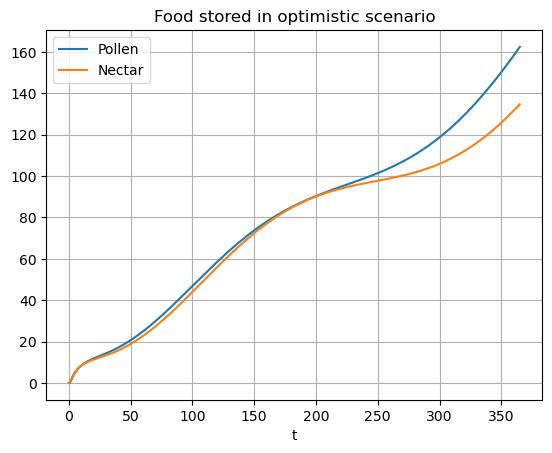

In [9]:
### Base case scenario
all_bees,hive_out = simulate_hive(hive_args_torch,bees,365)
derivs = get_derivs(hive_out,hive_args_torch,True)
present_results(all_bees,derivs,'optimistic')

,Young,Brood,HiveB,Pollen F,Nectar F,Pollen,Nectar
eggs,141.7,174.6,109.9,60.2,66.5,175.9,-5.5
hive\_bees\_for\_brood\_surv,-57.8,-74.0,-50.5,-27.7,-29.6,-102.2,-8.9
nectar\_for\_brood\_surv,-8.9,-10.8,-9.9,-4.6,-2.7,-39.2,22.8
pollen\_recruit\_rate\_1,-143.5,-205.3,-253.8,-69.2,-116.9,601.5,-175.0
pollen\_recruit\_rate\_2,-4.1,-6.4,-6.2,-3.4,-3.2,-9.8,-5.9
nectar\_rectuit\_rate\_1,155.5,246.5,175.2,111.4,144.1,-156.9,331.5
nectar\_recruit\_rate\_2,10.8,16.9,9.8,6.5,9.4,-30.5,28.6
excess\_foragers,-16.4,-42.9,55.2,-36.4,-27.4,-317.5,-141.5
1/larva\_duration,86.3,287.7,271.9,147.7,133.9,911.2,309.3
1/capped\_duration,13.5,-111.4,20.9,11.4,10.8,87.0,19.2


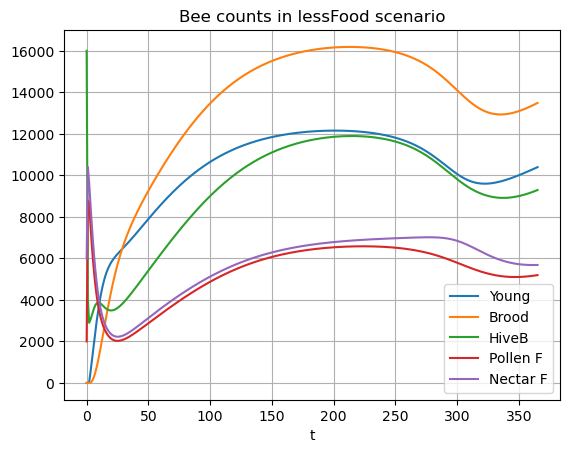

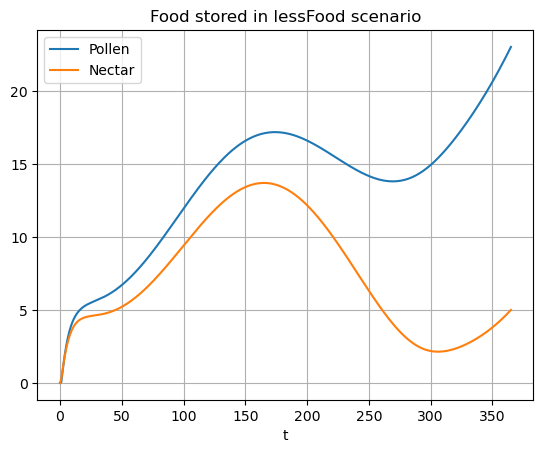

In [10]:
### Less food brought in by foragers
less_food = hive_args.copy()
less_food['c'] = 0.05
less_food_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in less_food.items()}
all_bees,hive_out = simulate_hive(less_food_torch,bees,365)
derivs = get_derivs(hive_out,less_food_torch,True)
present_results(all_bees,derivs,'lessFood')

,Young,Brood,HiveB,Pollen F,Nectar F,Pollen,Nectar
eggs,0.0,0.0,0.0,0.0,0.0,-16.9,-0.4
hive\_bees\_for\_brood\_surv,-0.0,-0.0,-0.0,-0.0,-0.0,11.8,0.5
nectar\_for\_brood\_surv,0.0,0.0,0.0,0.0,0.0,-0.6,0.8
pollen\_recruit\_rate\_1,-0.0,-0.1,-0.1,-0.1,-0.1,88.9,-1.9
pollen\_recruit\_rate\_2,-0.0,-0.0,-0.0,-0.0,-0.0,7.1,-0.2
nectar\_rectuit\_rate\_1,0.0,0.1,0.0,0.0,0.1,-39.6,2.0
nectar\_recruit\_rate\_2,0.0,0.1,0.0,0.0,0.1,-20.7,1.5
excess\_foragers,-0.0,-0.0,0.0,-0.0,-0.0,-25.0,-1.1
1/larva\_duration,0.0,0.0,0.0,0.0,0.1,11.7,0.5
1/capped\_duration,-0.0,-0.0,-0.0,-0.0,-0.0,-0.2,0.0


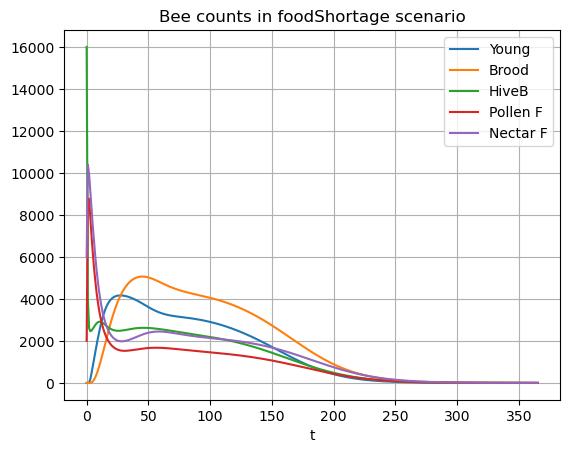

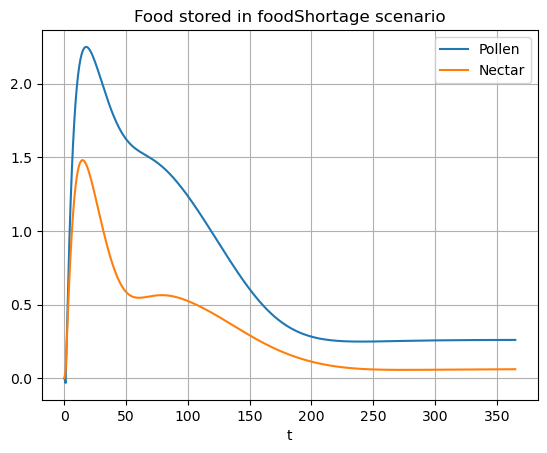

In [11]:
### Severe food shortage
less_food = hive_args.copy()
less_food['c'] = 0.025
less_food_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in less_food.items()}
all_bees,hive_out = simulate_hive(less_food_torch,bees,365)
derivs = get_derivs(hive_out,less_food_torch,True)
present_results(all_bees,derivs,'foodShortage')

,Young,Brood,HiveB,Pollen F,Nectar F,Pollen,Nectar
eggs,181.6,241.9,122.7,50.1,50.6,424.2,255.4
hive\_bees\_for\_brood\_surv,-78.6,-104.9,-53.5,-21.8,-21.9,-231.4,-155.4
nectar\_for\_brood\_surv,-5.6,-7.7,-5.0,-1.9,-1.4,-42.7,-6.4
pollen\_recruit\_rate\_1,-64.9,-86.9,-94.0,-4.6,-31.7,432.3,-507.6
pollen\_recruit\_rate\_2,-0.6,-0.9,-0.6,-0.2,-0.2,-9.5,-23.2
nectar\_rectuit\_rate\_1,-42.2,-55.9,-73.9,-24.5,1.4,-518.4,483.1
nectar\_recruit\_rate\_2,-1.1,-1.5,-1.8,-0.6,-0.1,-40.7,8.8
excess\_foragers,72.9,97.2,114.2,20.0,20.4,88.5,16.5
1/larva\_duration,-86.7,19.6,12.7,4.9,3.5,651.3,602.3
1/capped\_duration,2.0,-131.4,1.9,0.7,0.6,84.2,74.0


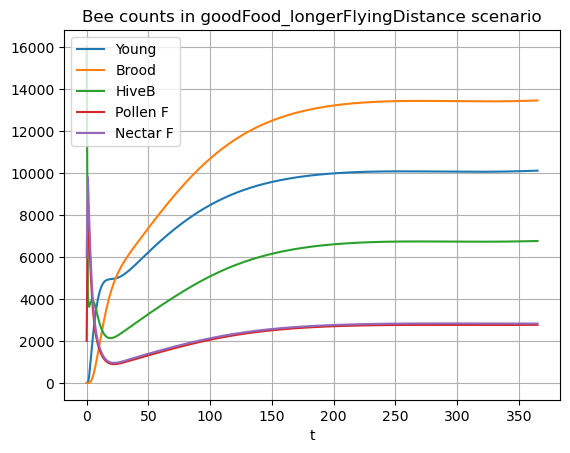

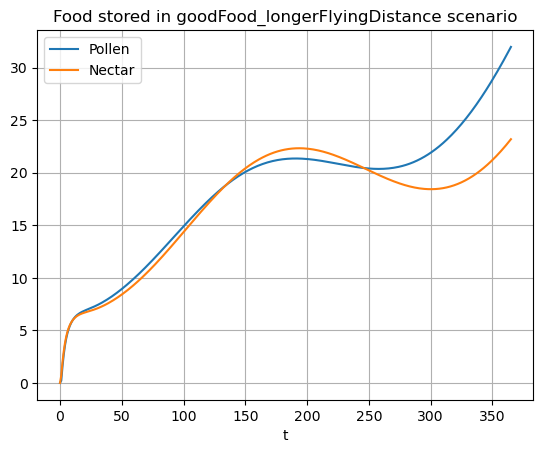

In [12]:
### Longer fly distance
fly_longer = hive_args.copy()
fly_longer['c'] = 0.025*4
fly_longer['m_p'] = 0.2
fly_longer['m_n'] = 0.2
fly_longer_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in fly_longer.items()}
all_bees,hive_out = simulate_hive(fly_longer_torch,bees,365)
derivs = get_derivs(hive_out,fly_longer_torch,True)
present_results(all_bees,derivs,'goodFood_longerFlyingDistance')

,Young,Brood,HiveB,Pollen F,Nectar F,Pollen,Nectar
eggs,-10.7,-24.9,-14.9,-4.7,-4.1,-72.6,-37.8
hive\_bees\_for\_brood\_surv,-6.7,-1.0,3.4,1.0,0.2,42.6,22.2
nectar\_for\_brood\_surv,-0.7,0.3,0.0,0.1,0.2,-1.4,15.3
pollen\_recruit\_rate\_1,-43.5,-45.1,-26.0,-2.7,-7.3,207.8,-37.0
pollen\_recruit\_rate\_2,-5.2,-6.8,-2.7,-0.9,-1.0,4.1,-2.9
nectar\_rectuit\_rate\_1,101.9,133.4,44.8,16.2,20.3,-82.6,87.1
nectar\_recruit\_rate\_2,8.8,11.0,2.7,1.1,1.8,-16.9,13.2
excess\_foragers,-37.9,-56.3,-11.8,-8.3,-8.4,-64.6,-36.4
1/larva\_duration,267.1,400.5,158.2,53.0,57.9,237.3,131.4
1/capped\_duration,11.1,-32.1,5.8,2.0,2.2,9.5,4.1


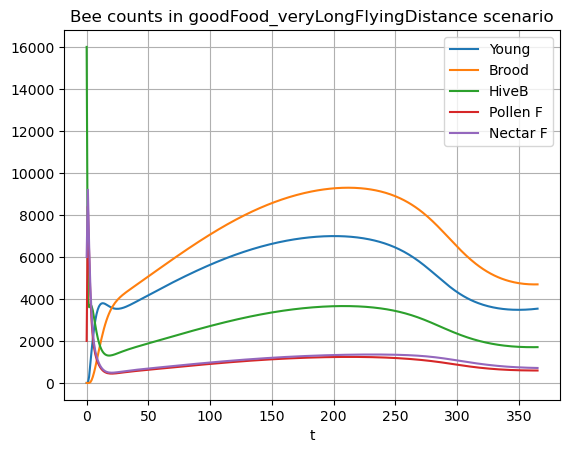

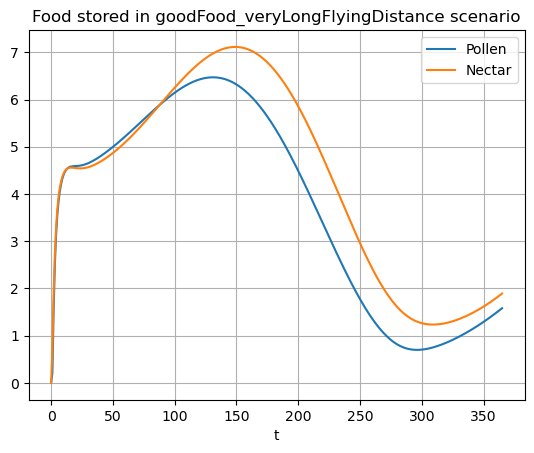

In [13]:
### very long fly distance
fly_longer = hive_args.copy()
fly_longer['c'] = 0.025*4
fly_longer['m_p'] = 0.3
fly_longer['m_n'] = 0.3
fly_longer_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in fly_longer.items()}
all_bees,hive_out = simulate_hive(fly_longer_torch,bees,365)
derivs = get_derivs(hive_out,fly_longer_torch,True)
present_results(all_bees,derivs,'goodFood_veryLongFlyingDistance')